
<img src="Speculate_logo2.png" width="500" align="centre"> 

## **THE ULTIMATE COOKBOOK GUIDE**
--------------------------------------------------------------------------------

#### *Goal:* Rapid emulation of a model spectrum through a pre-defined grid space given an observed spectrum.

With this cookbook, we describe the implimation of the original Starfish code, the changes we have done to allow a 'python' grid space to work and the expected variables needed from the code to insure correct operation. 

The code is broken up into stages for ease of reading from 1 to X. Most lines of code have comments to hint at what is happening.

#### <u>**Installation**</u>

To run, simply download the entire Speculate main branch, install package dependencies and run the cookbook. The download is large due to two spectrum grid's (kgrid and short_spec_cv_grid).

The speculate directory contains a number of items:
- <u>**Speculate Cookbook Guide.ipynb**</u> - This is the stable version of speculate. The python notebook contains information and explanations of the working code for you to use. This is the easiest way to run. 
- <u>**Speculate_dev.py**</u> - Dev version of speculate. This version is likely the most current iteration but may not run correctly. I run it in VS Code utilising a mix of intel/m1 anaconda environment's. With Jupyter extenstions, the `# %%` allows the code to be run like a notebook. Alternatively, you could simply run the file but you'll be unable to pause the code at certain points, which again may break the code if certain 0/1 switches in the code are incorrectly on/off.
- <u>**kgrid**</u> - This stores a ss-cygni cv test grid you can create an emulator from. You can place any cv data spectrum file from 'python' as a data/observation source in this directory. Example, like 'ss_cyg_1.spec'. Speculate can then attempt to find the parameters for this data/observation file (see stage 6). **sscyg_k2.ls** - Metadata of the kgrid (file names corresponding to parameters/variable names.)
- <u>**short_spec_cv_grid**</u> - This stores a default cv blackbody python v87a grid space of 3 parameters. For reference, a template.pf 'python' file is here that the grid was made from.
- <u>**plots**</u> - This is a dumping folder to place any saved plots in the code.
- <u>**Grid-Emulator_Files**</u> - This is where your saved grid, emulator and MCMC files are saved. Ensure your file names are systematic and explicit so that you can retrieve previous trained emulators and mcmc runs. Otherwise, you may rerun and overwrite accidentally. 
- <u>**Speculate_addons**</u> - This stores the additional import modules such as grid interfaces for Speculate's grids and other functions.
- <u>**Starfish**</u> - This is the original Starfish program. This stores the import module necessary for the program to run.
- <u>**.gitattributes** and **README.md**</u> - GitHub features. 



For my installation, I'm using a conda environment with python 3.9.13 and Starfish version 0.4.2 (most up to date version 4/4/23). The Starfish package is located within speculate's 'Starfish' directory and hopefully the code should look through your relative path to find starfish's classes/functions. You shouldn't separately need to install Starfish. You can see the Starfish Github here: https://github.com/Starfish-develop/Starfish. 

However, you are needed to install a suite of extra packages if you don't already have them. Not all might be listed here. 
- emcee ($conda install -c conda-forge emcee)
- arviz ($conda install -c conda-forge arviz)
- corner($conda install -c astropy corner)
- **NDtyping, ensure version 1.4.4** ($pip install nptyping==1.4.4), later versions cause issues I have yet to diagnose.

Keep doing $pip install or $conda installing until importing in Stage 1 stops yelling code errors at you. 

Once downloaded, installed and Stage 1 completes, you should be set! 

#### <u>**Stage 1** - The Imports and Functions</u>

This code block imports all the modules necessary, defines required classes for the python grid interface and has some further functions. The added Classes and function can be found in the Speculate_addons directory.

##### kgrid note:
With this build for faster computation time, we can smoothen the spectral flux of every grid point file. Smoothening is achieved by applying the `scipy.ndimage.gaussian_filter_1D()` within the `load_flux` function. The filter takes as inputs, the flux array and a value for the standard deviation of the gaussian kernel which smoothens the flux. I have set the standard deviation to 5, which seems to have a balance of computational time, detail in the spectrum and reducing autocorrelation in the pixels. This runs okay with 3, 4, maybe even 5 parameters. However, you may want to increase this to $10-50\sigma$ for faster computational time when testing with 6 parameters. 

In [1]:
# Stage 1) Imports and Speculate Grid Classes/funcitons for 'python'.

import os
import random
import emcee
import corner
import arviz as az
import math as m
import matplotlib.pyplot as plt
import multiprocessing as mp
import numpy as np
import scipy.stats as st
import Speculate_addons.Spec_functions as spec

from multiprocessing import Pool
from multiprocessing import cpu_count
from tqdm import tqdm
from scipy.ndimage import gaussian_filter1d
from Starfish.grid_tools import HDF5Creator
from Starfish.grid_tools import GridInterface
from Starfish.emulator import Emulator
from Starfish.emulator.plotting import plot_eigenspectra
from Starfish.spectrum import Spectrum
from Starfish.models import SpectrumModel
from Speculate_addons.Spec_gridinterfaces import KWDGridInterface
from Speculate_addons.Spec_gridinterfaces import ShortSpecGridInterface

#### <u>**Stage 2.1** - Setting up the Grid Space</u>

This code block sets up our python grid space in a HDF5 file, given the formatting within 'kgrid' or 'short_spec_cv_grid, to work with the Starfish framework.

-- You have seven inputs here! --

<u>'kgrid' switch</u>: For the kgrid space, we use the class called 'KWDGridInterface' which can read the spectrum files (.spec) within the 'kgrid/sscyg_kgrid090311.210901/' directory. We can use this grid by turning on the 'kgrid' switch from 0 to 1.

<u>'shortspec' switch</u>: For short_spec_cv_grid grid space, we use the class called 'ShortSpecGridInterface' which can read the spectrum files (.spec) within the 'short_spec_cv_grid' directory. We can use this grid by turning on the 'shortspec' switch from 0 to 1.

<u>model_parameters</u>: This is a tuple of the model parameters you wish to use for the emulator. You can input parameters in any order. Thoughout the code, the more parameters you have, the slower the computational time (scaling likely $O(n^3)$ due to the gaussian process training). 3 to 4 inputs are quite fast. Each parameter has a associated number here:

|  Parameter Number |  Kgrid | Shortspec  |
|---|---|---|
|  1 |  wind.mdot (msol/yr) | wind.mdot (msol/yr)  |
| 2  |  kn.d (wind geometry) | KWD.d (wind geometry)  |
|  3 |  kn.mdot_r_exponent |  KWD.v_infinity (in_units_of_vescape) |
|  4 |  kn.v_infinity (in_units_of_vescape) |  - |
|  5 | kn.acceleration_length (cm)  |  - |
|  6 |   kn.acceleration_exponent|  - |

<u>wl_range</u>: This is the wavelength range of your emulator grid space. This should be slightly smaller (or equal) than the wavelength range of your python grid space for general use. If you only want your emulator on a smaller part of the wavelength space, you can reduce this range input to reduce computational time. 

<u>scale</u>: This is not fully integrated yet. This string can be set to change the fluxes into 'linear', 'log' or 'scaled' space. In addition to changing the string here, you must change the default scale variable in your grid interface's `def load_flux` function. Scaled doesn't do much compared to linear as the fluxes when entering the pca decomposition are normalised. However, the 'scaled switch remains implimented. 'log' scale seems to only have minor effects on the data and potential to error. 'linear' is recommended by default. 

<u>emu_file_name</u>: Retired: This is the file name you wish to save your emulator under. You can also load existing trained emulator files with the correct file name. Use detailed file names to know what you are loading, you will only have to input this once. The comment in the code gives an example of my naming scheme. 

<u>grid_file_name</u>: Same as emu_file_name, however not so important as runtime is a second. Remains a default name 'grid_full'

##### Note to make new grid interfaces:
In future, if a different grid with the same formatting is used, you would need to change in stage 1: 
- 'The grid points in the parameter space' in `def __init__:`. 
- The example file naming scheme 'sscyg_k2_000000000000.spec' in `super().__init__()`. 
- The grid point's corresponding number in the file name eg, 1e-10: '00' and range(value) in the for loop depending on the number of parameters in `get_flux():`.

Follow the original naming scheme for all changes, **if** made. 


In [2]:
# Stage 2.1) Flux grid space (HDF5) setup and PCA inputs

""" 
-------------------------------------------------------------------------------|
                          - Set up your grid space! -
        Parameters of model            |            Parameters of model
        (kgrid/20years old)            |         (short spec cv grid/v87a)
-------------------------------------------------------------------------------|
1) wind.mdot (msol/yr)                 | 1) wind.mdot (msol/yr)
2) kn.d                                | 2) KWD.d
3) kn.mdot_r_exponent                  | 3) KWD.v_infinity (in_units_of_vescape)
4) kn.v_infinity (in_units_of_vescape) |
5) kn.acceleration_length (cm)         |
6) kn.acceleration_exponent            |
max_wl_range = (876, 1824)             | max_wl_range = (850, 1850)
-------------------------------------------------------------------------------|
"""

# ----- Inputs here -----------------------------------------------------------|
model_parameters = (1, 2, 3)  # Minimum 2 parameter tuple from table above
wl_range = (1510, 1590)       # Wavelength range of your emulator grid space.
                              # Later becomes truncated +/-10Angstom
                              
scale = 'linear'              # Transformation scaling for flux data. 'linear'
                              # 'log' or 'scaled'. scale not implemented yet.

grid_file_name = 'Grid_full'  # Builds fast, file save unnessary.
kgrid = 0                     # Turn on if planning to use kgrid
shortspec = 1                 # Turn on if planning to use shortspec_cv_grid

n_components = 4              # Alter the number of PCA components used.
# Integer for no. of components or decimal (0.0-1.0) for 0%-100% accuracy.
# -----------------------------------------------------------------------------|

# Sorting parameters by increasing order
model_parameters = sorted(model_parameters)
# Looping through parameters to create a string of numbers for file name
model_parameters_str = ''.join(str(i) for i in model_parameters)

# Selecting the specified grid interface 
if kgrid == 1:
    grid = KWDGridInterface(
        path='kgrid/sscyg_kgrid090311.210901/',
        wl_range=wl_range,
        model_parameters=model_parameters)
    # Change inclination with usecols[1]
    usecols = (1, 8) # Wavelength, Inclination 8-14 --> 40-70 degrees
    skiprows = 2  # Start of data within file
    inclination = usecols[1] * 5
    emu_file_name = f'Kgrid_emu_{scale}_{usecols[1]*5}inc_{wl_range[0]}-{wl_range[1]}AA_{n_components}comp_{model_parameters_str}'

if shortspec == 1:
    grid = ShortSpecGridInterface(
        path='short_spec_cv_grid/',
        wl_range=wl_range,
        model_parameters=model_parameters, 
        scale=scale
        )
    # Change inclination with usecols[1]
    usecols = (1, 16) # Wavelength, Inclination 10-21 --> 30-85 degrees
    skiprows = 81  # Starting point of data within file
    inclination = (usecols[1]-4) * 5
    emu_file_name = f'SSpec_emu_{scale}_{(usecols[1]-4) * 5}inc_{wl_range[0]}-{wl_range[1]}AA_{n_components}comp_{model_parameters_str}'
    
# Faster processing with python's .spec files into a hdf5 file
# Auto-generated keyname's required to integrate with Starfish
keyname = ["param{}{{}}".format(i) for i in model_parameters]
keyname = ''.join(keyname)
# Processing to HDF5 file interface
creator = HDF5Creator(
    grid,
    f'Grid-Emulator_Files/{grid_file_name}.hdf5',
    key_name=keyname,
    wl_range=wl_range)
creator.process_grid()

# Add custom name if auto generation undesired?
#emu_file_name = 'custom_name.hdf5' 

# Checking if the emulator file has been created
if os.path.isfile(f'Grid-Emulator_Files/{emu_file_name}.hdf5'):
    print(f'Emulator {emu_file_name} already exists.')
    emu = Emulator.load(f"Grid-Emulator_Files/{emu_file_name}.hdf5")
    emu_exists = 1
    print('Existing emulator loaded.')
else:
    print(f'Emulator {emu_file_name} does not exist.')
    emu_exists = 0
    print('Create new emulator in Stage 3.')

Processing Grid: [-8.52287875 16.          3.        ]: 100%|██████████| 125/125 [00:01<00:00, 94.25it/s]  


Emulator SSpec_emu_linear_60inc_1510-1590AA_4comp_123 already exists.
Existing emulator loaded.


#### <u>**Stage 2.2** - Spectral Data Exploration Tool</u>

 Plotting the Grid Space

In [3]:
# Stage 2.2) Speculate's spectral data exploration tool.

# The Class should open a new window to allow the user to explore the grid.
%matplotlib qt
plt.style.use('Solarize_Light2') # Plot Style (⌐▀͡ ̯ʖ▀) (ran twice as buggy-ish)
grid_viewer = spec.InspectGrid(grid, emu) # Emu (Emulator) optional

Available parameters:
{'param1': 'wind.mdot (msol/yr)', 'param2': 'KWD.d', 'param3': 'KWD.v_infinity (in_units_of_vescape)'}
Optional emulator loading.


100%|██████████| 125/125 [00:03<00:00, 38.89it/s]


#### <u>**Stage 3** - Generating and Training the Emulator</u>

This code block generates your emulator's grid from PCA decomposition and trains the emulator's hyperparameters by gradient decent with scipy.optimize.minimise.
This is complex and detailed in Appendix [Czekala et al. 2015](https://arxiv.org/pdf/1412.5177.pdf)

The `Emulator.from_grid` routine creates the emulator using a PCA decomposition. See the 'PCA with SVD workbook.pdf' in slack if you need a reminder about the PCA method. The fluxes are loaded, normalised, centred on the axis and whitened (divided by standard deviation). The sklearn.decomposition.PCA routine performs the PCA and outputs a set of weights and eigenspectra. The explained variance when truncated to a given number of components is also printed. 


The `emu.train()` routine trains the emulators hyperparameters. get_param_vector() is assigned to a variable P0 which is an array of the hyperparameters (variances, lengthscales, tuning parameter), which is described in Stage 4. This is placed into scipy.optimise.minismise with a loss function 'nll'. This 'nll' function determines the log_likelihood for the given set of hyperparamters. The log_likelihood is calculated in emulator.py/def log_likelihood(). I am probably going to need some help understanding this today and where i'm connecting this to the paper. It performs a Cholesky decomposition of $V_{11}$. $V_{11}$ is the 'covariance matrix of the fixed grid parameters'. `V11 = self.iPhiPhi / self.lambda_xi + batch_kernel(self.grid_points, self.grid_points, self.variances, self.lengthscales)`. Further description of $V$ covariance matrices in Stage 4. Then there's some more maths, likely determining the log_likelihood. The hyperpararmeters update with set_param_vector() and recalculate the $V{11}$ matrix for the next log_likelihood function iteration. 

**Previous version text, not guaranteed correct but don't want to get rid of it just yet**

 However, a summary is that we optimise the likelihood function for a set of extrinsic and model parameters. The weights from the PCA decomposition is treated as a grid. Then, a gaussian process treat the weights grid as draws from a multivariate Gaussian distribution, with a square exponential kernel defining the hyperparameters. 

**Back to usual programming**

The 'scipy.optimise.minisise' routine chosen by Starfish devs was the 'Nelder-Mead' routine, with a maximum number of 1e5 iterations. This iteration number can be changed by `maxiter=`. To note, the `log_likelihood` function within the training uses scipy's linear algebra module (`scipy.linalg`) by doing cho factor calculations. The linear algebra module has parallization built in so these calculations scales to the number of CPU's you have ($CPU_{X}-2$). Note: the blas libraries of scipy is important. Intel python architecture is much faster than M1 at current. Meanwhile, the inverse is true for numpy using the m1 accelerate blas library. 

-- You have one input here! --

`n_components` controls the number of components (eigenspectra) you wish to truncte to when performing your PCA decomposition. You can specify the number of eigenspectra generated by setting a integer between 1 to the maximum number of grid points. You could also specify the number of components between 0.01-0.99. A decimal will let the PCA truncate the number of eigenspectra to the percentage of variance described by the decimal. E.g. 0.85 will produce X number of eigenspectra that describes 85% of the variance. 

In [4]:
# Stage 3) Generating and training a new emulator

# Asking if user wants to continue training a new emulator
if emu_exists == 1:
    print("Emulator's name:", emu_file_name)
    print('Do you want to overwrite the existing emulator (y/n)?')
    if input('y/n: ') == 'y':
        emu_exists = 0
        print('Existing emulator will be overwritten')
    else:
        print('Existing emulator will be used')

# Generating/training/saving and displaying the new emulator
if emu_exists == 0:
    emu = Emulator.from_grid(
        f'Grid-Emulator_Files/{grid_file_name}.hdf5',
        n_components=n_components,
        svd_solver="full") 
    # scipy.optimise.minimise routine
    emu.train(method="Nelder-Mead", options=dict(maxiter=1e5, disp=True))
    emu.save(f'Grid-Emulator_Files/{emu_file_name}.hdf5')
    print(emu)  # Displays the trained emulator's parameters

Emulator's name: SSpec_emu_linear_60inc_1510-1590AA_4comp_123
Do you want to overwrite the existing emulator (y/n)?
Existing emulator will be used


If Stage 3 emulator training has yet to converge, continue the training with the cell below

In [ ]:
# Stage 3 not converged?: Continue training emulator

emu.train(method="Nelder-Mead", options=dict(maxiter=1e5, disp=True))
emu.save(f'Grid-Emulator_Files/{emu_file_name}.hdf5')  # Saving the emulator
print(emu)

#### <u>**Stage 4** - Plotting the Emulator</u>

This code block plots the gaussian process emulator's trained weights for each principle component. 

The plotting function works by taking the emulator ('emu') and pulling out every weight value from the PCA decomposition for the plotting parameter combination integers you have specified. Example here, varying parameter 1 and fixed 2 index grid point values for the other 2 parameters in the shortspec grid space. These are plotted as blue dots. 

Then, the function takes 100 evenly spaced x axis values within the range of your varying parameter and plugs these x values (these are possible parameter 1 values) into the emulator. The emulator outputs corresponding mean $\mu$ and covariance matrix $\Sigma$ values through the kriging equations, code in def__call__(). $\mu$ is recalculated by $\mu = V_{21}V_{11}^{-1}\hat{w}^{grid}$. $V_{21}$ is the transpose of $V_{12}$, which is a covariance matrix between the fixed grid point parameters and the new interpolate parameters desired. $V_{11}$ is the covariance matrix of the fixed grid parameters. $\hat{w}^{grid}$ "I think" is the fixed maximum likelihood estimates (MLE) for the likelihood function. The MLE is for a given statistical error value $\lambda_{\xi}$ between the emulator trying to reproduce the original eigenspectra. Subsequently, the mean's weight value's are plotted as a green line. 

In the code, the $V$ covariance matrices are made through a batch_kernel, which utilises a radial basis function. This is equivalent to the squared exponential kernel. The variance hyperparameter is set as 10,000. The lengthscale hyperparameter of each parameter ($N_{param}$) is set as 3 times the maximum grid separation (info found in emulator.py/def __init__():). The combination for the number of PCA components ($N_{comp}$), a variance ($a$) value for each kernel and the lengthscale ($l$) values equal in amount to the number of parameters ($N_{params}$), gives total number of hyperparamters, $N_{comp}*(1_a+N_{params}*1_l)+ 1$. +1 is the tuning hyperparameter, set at 1. 

$\Sigma$ is recalculated by $\Sigma = V_{22} - V_{21}V_{11}^{-1} V_{12}$. $V_{22}$ is squared exponential kernel with "zero-spacing parameter pairs", the new interpolation parameters twice, $\Kappa(\theta_i, \theta_i | \phi)$.
The 2nd standard deviation ($2\sigma$) values are taken from the covariance matrix's diagonal and plotted as the confidence interval.  

(TO BE IMPLIENTED) - Plotting out the eigenspectra generated from the PCA. The plot displays the mean eigenspectra ($\xi_u$) and the component eigenspectra ($\xi_N$), which corresponds to the N component weights plot


-- You have two inputs here! --

<u>plot_emulator</u>:

You can change which parameter weights are plotted by changing the first integer in the `plot_emulator()` function to the corresponding parameters number (table in stage 2). 

All the other parameters are fixed at the index grid point specified by the second integer. The integer is zero indexed, hence, range is number of grid points. Example, 5 grid points gives possible integers between 0 and 4.


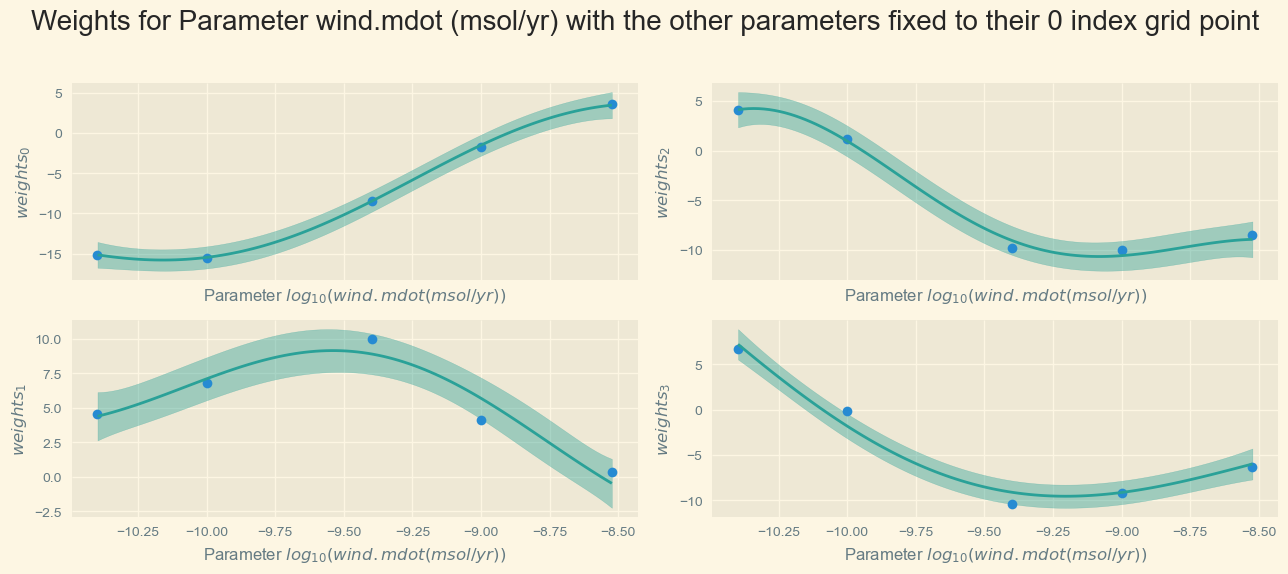

In [6]:
# %% Stage 4) Plotting the emulator's eigenspectra and weights slice TODO

%matplotlib inline

# Inputs: Displayed parameter (1-X), other parameters' fixed index (0-(X-1))
spec.plot_emulator(emu, grid, 1, 0)
# plot_new_eigenspectra(emu, 51)  # <---- Yet to implement

#### <u>**Stage 5** - The Emulator's Covariance Matrix</u>

This code block isn't necessary for the emulator to work. However, may be interesting to you. A random set of emulator grid plots are chosen and the emulators covariance matrix is plotted. This is likely more useful as a diagnostic tool for when things might break or for some reason you wish to change the Gaussian processes' kernel. Again, described in Appendix [Czekala et al. 2015](https://arxiv.org/pdf/1412.5177.pdf). 

The code cell loads your emulator file, ensure this is the correct file you wished to view. Default in this notebook is the same file as saved in Stage 4.

Random Grid Point Selection
['param1', 'param2', 'param3']
[-10.39794001   2.           1.        ]
[-8.52287875  8.          2.        ]


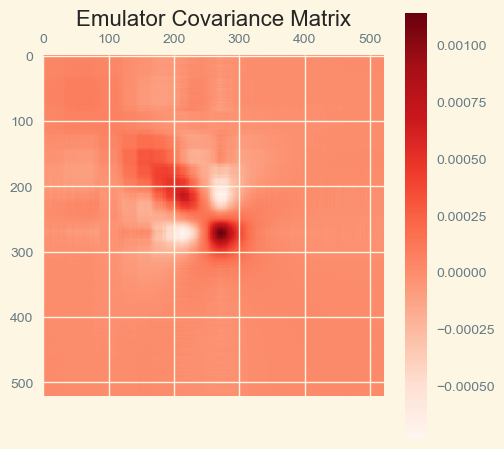

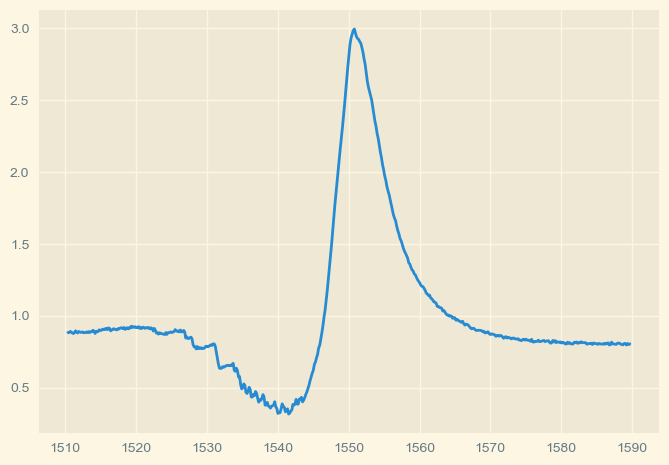

In [15]:
# Stage 5) Plotting the emulator's covariance matrix

emu = Emulator.load(f"Grid-Emulator_Files/{emu_file_name}.hdf5")
random_grid_point = random.choice(emu.grid_points)
print("Random Grid Point Selection")
print(list(emu.param_names))
print(emu.grid_points[0]) # put emu.grid_points[0] 
print(random_grid_point) # or put: random_grid_point in next line
weights, cov = emu(random_grid_point) # here !!!
X = emu.eigenspectra * (emu.flux_std)
flux = (weights @ X) + emu.flux_mean
emu_cov = X.T @ cov @ X
plt.matshow(emu_cov, cmap='Reds')
plt.title("Emulator Covariance Matrix")
plt.colorbar()
plt.show()
plt.plot(emu.wl, flux)

#### <u>**Stage 6** - Reading in Observational Data or Generating Test Data</u>

This code block is now the point you would introduce your observed spectrum from your target. In our case here, there is four method options for what type of test spectrum you wish to model against. These spectrum are:

    1) A grid point 
    2) A noisy version of a grid point
    3) Interpolation between a few grid point spectrum (method detailed in section)
    4) A custom test file from python

-- You have four switches and four sets of inputs here depending on the four methods! --

For which method you choose, turn on (1) one of the data_(X) values. For the corresponding data_(X) input:

1) Takes a grid point file as the data spectrum. You only need to specify which grid point file you want. The 'kgrid' follows the naming scheme where each parameters grid points corresponds to a two digit value XX (eg 06). So every file for the 6 parameters 'kgrid' has a 12 digit string ordered as the parameters are in Stage 2. For a quick look up of the grid point/digit combination, within the definition for the `get_flux()` function in Stage 1, see the dictionary entries for the `param(X)_name`.
2) Similar to 1. This takes a specified grid point spectral file but adds random gaussian noise onto each flux value. You can control the level of noise with the `noise_std` input. The input changes the standard deviation (width) of the normal distribution, where $1\sigma$  is the standard deviation of all the flux values. 
3) Yet to be implemented! This will take a data file and it's nearest two index grid point files. These's three files are then interpolated to generate a new file as the data spectrum. Method to be detailed later. 
4) Similar to 1. This take a Python v87a spectral file. Ensure the file is located within the 'kgrid' folder. 

Upon completion a plot of your data spectrum should be shown. 

run59_WMdot4e-10_d5_vinf2p5.spec


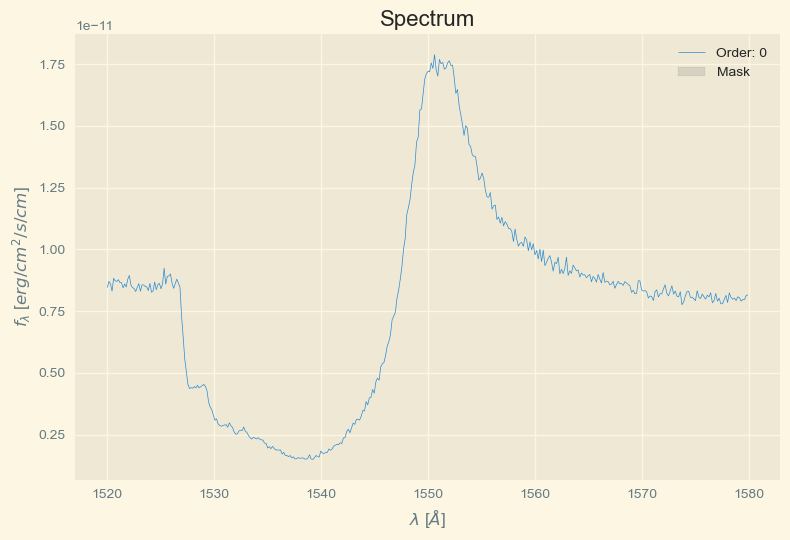

In [16]:
# Stage 6) Adding observational spectrum as data

%matplotlib inline

# ---------- Switches here -----------|
# Four methods to select which type of testing spectrum file you want:
# Turn off/on (0/1) to use this method
data_one = 0                # [1] A kgrid grid point
data_two = 0                # [2] A noisy grid point
data_three = 0              # [3] Interpolatation between two grid points
data_four = 1               # [4] A custom test file from python
# ----------------------------------------------------------------------------|

# ----------- Inputs here ------------|
if data_one == 1:
    # File corresponds to grid points in section 2
    # Parameter's point given by the XX number in the name (6 params = 12 digits)
    # 040102000000 = 4.5e-10, 16, 1, 1, 1e10, 3
    file = 'sscyg_k2_040102000001.spec'
    
    waves, fluxes = np.loadtxt(
        f'kgrid/sscyg_kgrid090311.210901/{file}', usecols=usecols, unpack=True, skiprows=skiprows)
# -------------------------------|
# -------------------------------|
if data_two == 1:
    file = 'sscyg_k2_040102000001.spec'  # File naming same as 1)
    noise_std = 0.50                    # Percentage noise (0.05 sigma)
    
    waves, fluxes = np.loadtxt(
        f'kgrid/sscyg_kgrid090311.210901/{file}', usecols=usecols, unpack=True, skiprows=skiprows)
    noise = noise_std * np.std(fluxes)
    for i in range(len(waves)):
        fluxes[i] = np.random.normal(fluxes[i], noise)       
# -------------------------------|
# -------------------------------|
if data_three == 1:
    print('to do') # TODO
# -------------------------------|
# -------------------------------|
# Python v87a formatting. Place python file within kgrid folder/directory
if data_four == 1:
    file = 'run59_WMdot4e-10_d5_vinf2p5.spec' # < CHANGEABLE
    #file = 'runtest_WMdot2e-10_d14_vinf1p5.spec'

    waves, fluxes = np.loadtxt(
        f'observation_files/{file}', unpack=True, usecols=usecols, skiprows=skiprows)
# -------------------------------|   
# -------------------------------|

# Data manipulation/truncation into correct format.
wl_range_data = (wl_range[0] + 10, wl_range[1] - 10)  # Truncation
waves = np.flip(waves)
fluxes = np.flip(fluxes)
# fluxes = gaussian_filter1d(fluxes, 50)
if scale == 'log':
    fluxes = [np.log10(i) for i in fluxes]  # log
    fluxes = np.array(fluxes)  # log
if scale == 'scaled':
    fluxes /= np.mean(fluxes)
indexes = np.where((waves >= wl_range_data[0]) & (
    waves <= wl_range_data[1]))  # Truncation + next 2 lines
waves = waves[indexes[0]]
fluxes = fluxes[indexes[0]]
raw_flux = list(fluxes)
sigmas = np.zeros(len(waves))
data = Spectrum(waves, fluxes, sigmas=sigmas, masks=None)
data.plot(yscale="linear")
print(file)

#### <u>**Stage 7** - Autocorrelation within the Test Data</u>

TODO: Update to new requirements. - IMPORTANT IF USING GAUSSIAN FILTERS ON DATA!

This code block determines the pixel autocorrelation within your data spectrum. To accurately measure the autocorrelation, the data is passed through a high pass filter to remove trends within the spectrum that effects the result. You have two plots outputted. The plot showing the high-pass filter adjusted flux data and a plot showing the autocorrelation between pixels from your data. 

-- You have three inputs here! --

1) `high_pass_sigma`, similarly to the use of the `gaussian_filter1D` is stage 1, controls the value for the standard deviation of the gaussian kernel which smoothens the flux. The high pass filter's `gaussian_filter1d` function takes the already smoothened data from stage 1 and again applies the smoothening filter. As a result, the `high_pass_sigma` value should be multiples greater than the value used in stage 1 (defaulted at 5). The plot outputted from this stage can be run over and over again to improve the fitting performance of the high pass filter to the trend of the data. However, be warned! The higher the value of the `high_pass_sigma`, the trend in the high-pass filter wraps towards $y=c$ and no longer fits the data well. Too low of a value will result in remove detail from the spectrum. So a compromise has to be made between the two. This is purely a qualitative adjustmeant at the moment (room for improvement) and is left to the user for adjustment depending on their individual data case. 
2) `lags` is a simple input to control range of the pixel shift in the autocorrelation plot. The greater the value, the greater the comparison shift. The lags value gives positive and negative range, resulting in $-lags \leq 0 \leq +lags$.
3) `percent` controls the ability to cut strong spectral lines out of your high pass filter. If your data contains strong lines, the gaussian filter will be unable to smoothen out these lines 'bumps' with any reasonable value for the `high_pass_sigma`. As a result, you'll lose important correlation information at these line's wavelengths. The solution is to cut out the spectral line from the high-pass filter by using `percent`. (Method - Improvements likely to be implemented later). The spectrum is fit with a quadratic to unveil close to your data's trend. `Percent` controls the standard deviation boundary of the fit (eg. $0.5 = 0.5\sigma$ or $2 = 2\sigma$). These boundaries are plotted in $\color{orange}{\text{orange}}$. If any flux value crosses this boundary, that flux value +/- 10 of the neighbouring pixels are changed to the quadratically fitted line's value plus 5% random gaussian noise. This is NOT to remove noise from your data, but just unexpected large spectral lines. 

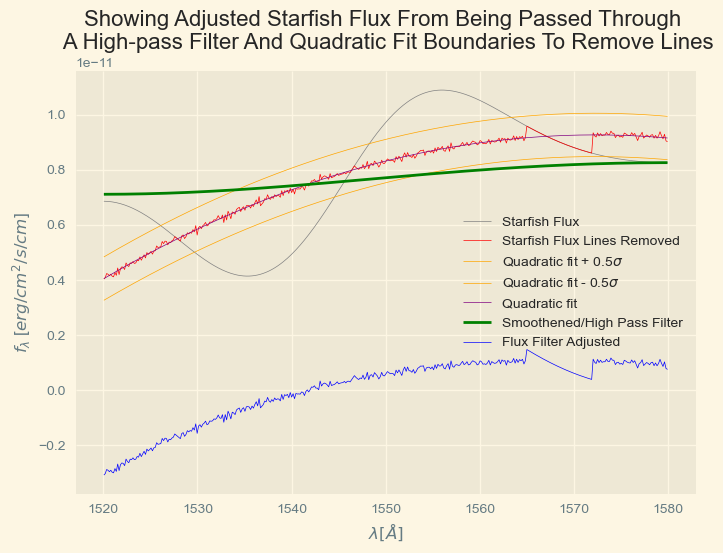

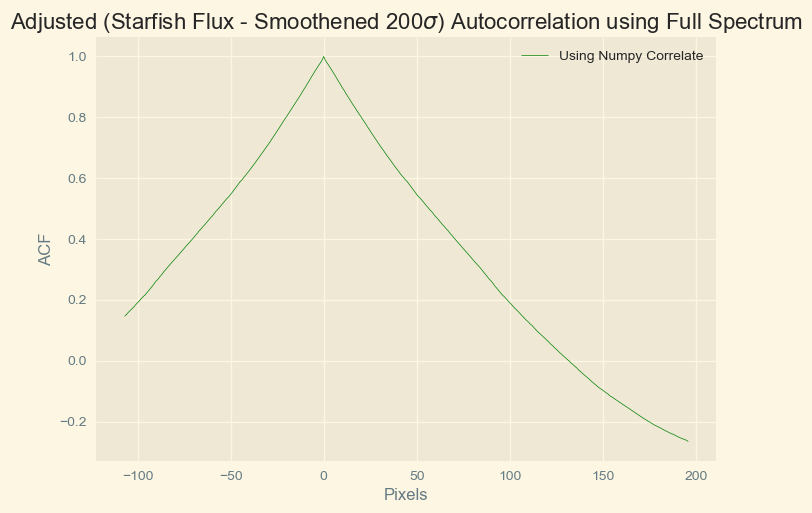

In [17]:
# Stage 7) Measuring the autocorrelation of pixels.

# ----- Inputs here ------|
# Value of sigma (standard deviation) for the size of filter's gaussian
# kernel in the high pass filter. The larger the value, the smoother the flux
# data but baseline can warp to y = c
high_pass_sigma = 200

# +/- range (aka lags) of the pixels for the autocorrelation plot.
lags = 500

# Specify the standard deviation of the quadratric fit boundaries to
# remove lines.
percent = 0.5
# ------------------------|


def quadratic(x, coefficients):
    """Returns y value for a given x value and coefficients of a quadratic"""
    return coefficients[0] * (x**2) + coefficients[1] * (x) + coefficients[2]


# Alter startfish_flux sigma too (↓) if changing the smoothening term in
# the class KWDGridInterface(GridInterface):
# Smoothened data used for the emulator input
starfish_flux = gaussian_filter1d(raw_flux, 50)
# Really weird bug if not with list!
starfish_flux_original = list(starfish_flux)
# Coefficients of a quadratic fitting routine
coefficients = np.polyfit(waves, starfish_flux, 2)
fit = [quadratic(i, coefficients)
       for i in waves]   # Y values for the quadratic best fit
std1 = np.std(fit)                     # Percent standard deviation of best fit
# Plus 1 standard deviation of best fit for detecting lines
fit_err_plus = fit + (percent * std1)
# Minus 1 standard deviation of best fit for detecting lines
fit_err_minus = fit - (percent * std1)

# Cutting out large emission/absorption lines. Not efficient but too fast to worry about. Reduces large bumps in high pass filter
# Fluxes greater than 1 std have indexes +/- 10 intervals flux values
# replaced by the quadratic fit+noise.
out_of_bounds_indexes = [1 if starfish_flux[i] >= fit_err_plus[i] or starfish_flux[i] <=
                         fit_err_minus[i] else 0 for i in range(len(waves))]  # Detecting lines >1std from fit
for i in range(len(waves)):
    if out_of_bounds_indexes[i] == 1:
        if i < 10:  # if/elif/else statement checking boundaries to stop errors
            waves_limit = range(0, i + 11)
        elif i > (len(waves) - 11):
            waves_limit = range(i - 10, len(waves))
        else:
            waves_limit = range(i - 10, i + 11)
        for j in waves_limit:  # +/- 10 flux intervals
            # change line flux with fit flux plus 5% noise.
            starfish_flux[j] = np.random.normal(fit[j], (0.05 * std1))

# High-pass filter for the starfish flux trend.
smooth_flux = gaussian_filter1d(starfish_flux, high_pass_sigma)
# Starfish data with underlying flux removed.
adj_flux = starfish_flux - smooth_flux

plt.plot(
    waves,
    starfish_flux_original,
    color="grey",
    label='Starfish Flux',
    linewidth=0.5)
plt.plot(
    waves,
    starfish_flux,
    color='red',
    label='Starfish Flux Lines Removed',
    linewidth=0.5)
plt.plot(
    waves,
    fit_err_plus,
    color='orange',
    label=f'Quadratic fit + {percent}$\\sigma$',
    linewidth=0.5)
plt.plot(
    waves,
    fit_err_minus,
    color='orange',
    label=f'Quadratic fit - {percent}$\\sigma$',
    linewidth=0.5)
plt.plot(waves, fit, color='purple', label='Quadratic fit', linewidth=0.5)
plt.plot(waves, smooth_flux, color='green',
         label='Smoothened/High Pass Filter')
if scale == 'linear' or scale == 'scaled':
    plt.plot(
        waves,
        adj_flux,
        color='blue',
        label='Flux Filter Adjusted',
        linewidth=0.5)
plt.xlabel('$\\lambda [\\AA]$')
plt.ylabel('$f_\\lambda$ [$erg/cm^2/s/cm$]')
plt.title('Showing Adjusted Starfish Flux From Being Passed Through \n A High-pass Filter And Quadratic Fit Boundaries To Remove Lines')
plt.legend()
plt.show()
if scale == 'log':
    plt.plot(
        waves,
        adj_flux,
        color='blue',
        label='Flux Filter Adjusted',
        linewidth=0.5)
    plt.xlabel('$\\lambda [\\AA]$')
    plt.ylabel('$f_\\lambda$ [$erg/cm^2/s/cm$]')
    plt.legend()
    plt.show()

# Numpy's autocorrelation method for comparison checks.
mean = np.mean(adj_flux)
var = np.var(adj_flux)
ndata = adj_flux - mean
acorr = np.correlate(ndata, ndata, 'same')
acorr = acorr / var / len(ndata)
pixels = np.arange(len(acorr))
if len(acorr) % 2 == 0:
    pixels = pixels - len(acorr) / 2
else:
    pixels = pixels - len(acorr) / 2 + 0.5
indx = int(np.where(pixels == 0)[0])
lagpixels = pixels[indx - lags:indx + lags + 1]
lagacorr = acorr[indx - lags:indx + lags + 1]
plt.plot(
    lagpixels,
    lagacorr,
    color='green',
    label='Using Numpy Correlate',
    linewidth=0.5)
plt.title(
    f'Adjusted (Starfish Flux - Smoothened {high_pass_sigma}$\\sigma$) Autocorrelation using Full Spectrum')
plt.ylabel('ACF')
plt.xlabel('Pixels')
plt.legend()
plt.show()

#### <u>**Stage 8** - Kernel Calculators</u>

This code block is calculators which give estimate global kernel values for the next code block in stage 9. A full description will be given in stage 9, but the original method by the starfish was to repeatedly guess values until you find a good value. Starfish's read-the-docs also don't help as the example given does not tally up with the latest code release. The calculator should do the work, however, visually check the values in stage 9 still to be sure. 

THE CALCULATORS ARE YET TO BE IMPLIMENTED 
list of possible grid_params
log_amp calculator 
log_ls calculator

In [18]:
# Stage 8.1) Kernel Calculators"""

# TODO: Implement kernel calculators for the emulator's global matrix

In [20]:
# Stage 8.2) Search grid point indexes for Stage 9"""

spec.search_grid_points(1, emu, grid) # <-- 1/0 switch for on/off

- Search index range 0 to 124 to find the associated grid point values.
- Type '-1' to stop searching.
- Or type [Input, Parameter, Values] in a list for the specific grid point.
- No square brackets needed, just commas.
- Increasing the index increases the parameters grid points like an odometer.
---------------------------------------------------------------
Names: ['param1' 'param2' 'param3']
Description: ['wind.mdot (msol/yr)', 'KWD.d', 'KWD.v_infinity (in_units_of_vescape)']
-----------------------------------------------------------
Emulator grid point index 20 is [-10.397940008672037, 16.0, 1.0]
-----------------------------------------------------------
Emulator grid point index 50 is [-9.397940008672037, 2.0, 1.0]
-----------------------------------------------------------
Grid point [-10.397, 16.0, 1.0] is not in the emulator
-----------------------------------------------------------
Parameter's [-10.3979, 16.0, 1.0] is at emulator grid point index 20
-----------------------

#### <u>**Stage 9** - Assigning the Model with the Emulator and Data</u>

This block of code is first point we assign our model. `SpectrumModel` is a class which stores as a variable, our emulator we have generated, the observation data we have read in (test data) and initial parameter guesses for our emulator to match the data BEFORE training. Let's go through each one by one! There are five (more *args optional) needed arguements for `SpectrumModel`
1) The name of your emulator file - This is a string of the file name we saved our emulator as in Stage 4. Other emulators could be loaded here if compatible formatting in the wavelength/grid space.
2) The observation data (test data) variable - This is set for you in stage 6. 
3) `grid_params = [...]` - This is an initial grid point guess for the emulator to match up with the test data. It's necessary in order to set-up parameter dictionarys within the Class. If you call `model.plot()`, you can see how the output changes with different emulator grid points when compared to the test data. However, the exact grid point used isn't important as the model is trained in a later stage.
4) `global_cov=dict(log_amp=X)` -  The `log_amp` is setting the global convariance kernel's amplitude value as a natural logarithm (ln, not log as code by Starfish, Changes to be implemented). The kernel used is the Matern 3/2 kernel defined in velocity space [km/s] (using velocity separation between pixels), where +3/2 is the half integer for the Matérn class of kernels. The value needs to be changed so the standard deviation contours in the top right residuals plot look reasonable ($\Delta f_{\lambda}$). This initial guess is for better training of the model in later stages. (The contours look very flat at the moment given the data. Need to investigate.)
5) `global_cov=dict(log_ls=X)` - The `log_ls` is setting the global convariance kernel's lengthscale value as a natural logarithm (ln, not log as code by Starfish, Changes to be implemented). The trunction of the Hann window in the global kernel is operated by a lengthscale multiple (6 times default). This controls the sparseness of the covariance matrix. 

The cell also outputs the plot of the global convariance matrix and the sum of the covariance matrices with the emulator's matrix. (check).

You are able to freeze any hyperparameter to remain fixed when training with `model.freeze("X")`. The list of available hyperparameters can be found by using `model.get_param_dict`. 



SpectrumModel
-------------
Data: Spectrum
Emulator: Grid-Emulator_Files/SSpec_emu_linear_60inc_1510-1590AA_4comp_123
Log Likelihood: None

Parameters
  Av: 0
  global_cov:
    log_amp: -52
    log_ls: 5
  param1: -9.0
  param2: 5.0
  param3: 1.0
  log_scale: -25.615454445868732 (fit)


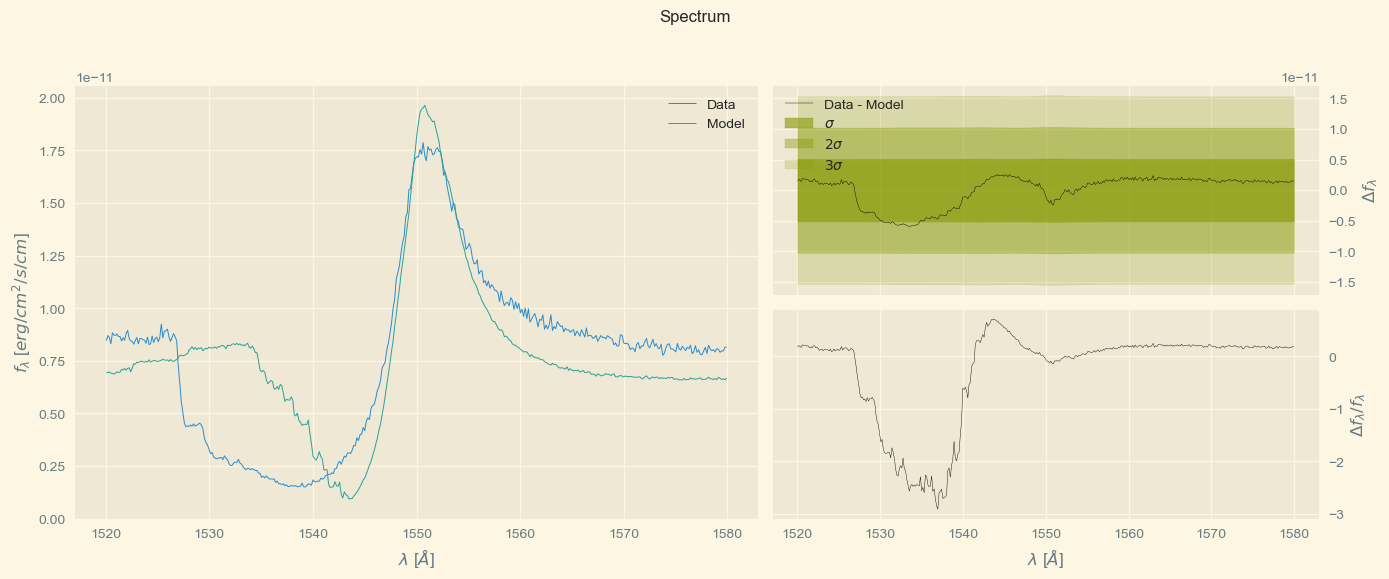

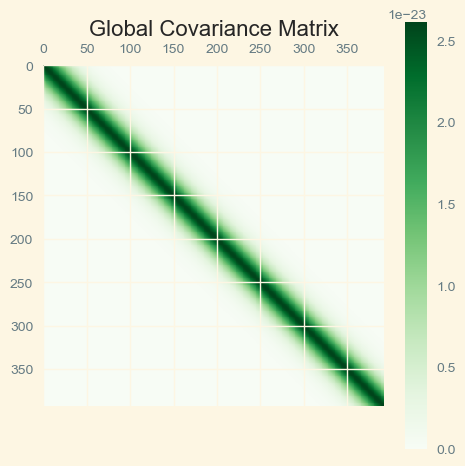

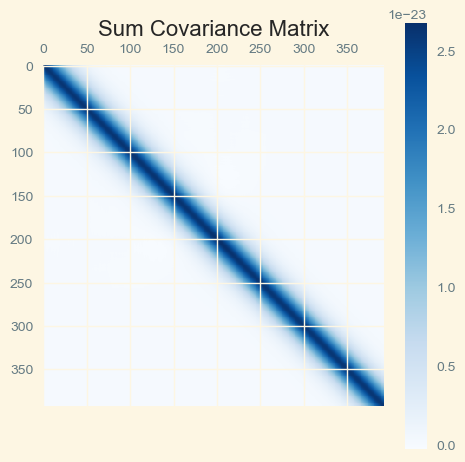

-- Model Labels --
('global_cov:log_amp', 'global_cov:log_ls', 'param1', 'param2', 'param3')


In [21]:
# Stage 9) Assigning the model and initial model plot"""

# ----- Inputs here ------|
# Natural logarithm of the global covariance's Matern 3/2 kernel amplitude
# log=-52 'linear', log=-8 'log'
log_amp = -52
# 5Natural logarithm of the global covariance's Matern 3/2 kernel lengthscale
log_ls = 5
# ------------------------|

model = SpectrumModel(
    f'Grid-Emulator_Files/{emu_file_name}.hdf5',
    data,
    # [list, of , grid , points]emu.grid_points[119] [-8.95, 10.26, 1.82]
    grid_params=list(emu.grid_points[80]),
    Av=0,
    global_cov=dict(log_amp=log_amp, log_ls=log_ls)
)
print(model)
model.plot(yscale="linear")
model_flux, model_cov = model()
plt.matshow(model._glob_cov, cmap='Greens')
plt.title("Global Covariance Matrix")
plt.colorbar()
plt.show()
plt.matshow(model_cov, cmap='Blues')
plt.title("Sum Covariance Matrix")
plt.colorbar()
plt.show()
model.freeze("Av")
print("-- Model Labels --")
print(model.labels)

#### <u>**Stage 10** - Assigning the Priors for MLE and MCMC</u>

This code block assigns the hyperparamter priors for when we perform MCMC on the model to determine their values. 

The recommendation is to largely use uniform priors across the parameter range unless certain of a result. The local kernel priors are recommended as uniform except for the width parameter. The width is logistic and at values below line-of-sight velocity distribution is flat. Above tapers to 0. This lets the global kernel do its work without local kernels attempting to interfere. 

Ensure the priors are within the grid parameter space! **Be warned**! With `st.uniform` the range is set by (x, y) where the distribution range will be from [$x$ to $x+y$].

In [22]:
# Stage 10) Assigning the mcmc priors

# Default_priors contains a distribution for every possible parameter
# Mostly uniform across grid space bar global_cov being normal
# Change the default distrubtion if you wish something different.
# WARNING! st.uniform(x, y) is range(x, x+y)
if kgrid == 1:
    default_priors = {
        "param1": st.uniform(1.0e-10, 2.9e-9),
        "param2": st.uniform(4, 28),
        "param3": st.uniform(0.0, 1.0),
        "param4": st.uniform(1.0, 2.0),
        "param5": st.uniform(1e+10, 6e+10),
        "param6": st.uniform(1.0, 5.0),
        "global_cov:log_amp": st.norm(log_amp, 10),
        "global_cov:log_ls": st.uniform(0.1, 10.9),
        "Av": st.uniform(0.0, 1.0)
    }
if shortspec == 1:
    default_priors = {
        # log10 values
        "param1": st.uniform(np.log10(4e-11), (np.log10(3e-9) - np.log10(4e-11))),
        "param2": st.uniform(2, 14),
        "param3": st.uniform(1.0, 2.0),
        "global_cov:log_amp": st.norm(log_amp, 1),
        "global_cov:log_ls": st.uniform(1, 7),
        "Av": st.uniform(0.0, 1.0)
    }

priors = {}  # Selects the priors required from the model parameters used
for label in model.labels:
    priors[label] = default_priors[label]  # if label in default_priors:

#### <u>**Stage 11** - Training the Model for Estimating Likelihood and Posteriors (MLE/MAP)</u>

This code block triggers the training of the model and priors we just made. The `train` function calculates the maximum likelihood estimate for the model in it's current state. Then with scipy.minimize.optimise, the model continues to estimate the posterior distribution through the maximum a posterior. 

In [23]:
# Stage 11) Training the model with scipy.optimise.minimize(nelder-mead method)

# TODO: SIMPLEX - Need to add global covariance hyperparameters
initial_simplex = spec.simplex(model, priors) 
model.train(
    priors,
    options=dict(
        maxiter=1e5,
        disp=True,
        initial_simplex=initial_simplex,
        return_all=True))
print(model)

Optimization terminated successfully.
         Current function value: -11124.128913
         Iterations: 396
         Function evaluations: 663
SpectrumModel
-------------
Data: Spectrum
Emulator: Grid-Emulator_Files/SSpec_emu_linear_60inc_1510-1590AA_4comp_123
Log Likelihood: 11140.425186197992

Parameters
  global_cov:
    log_amp: -56.35215153846589
    log_ls: 2.8637792334474987
  param1: -9.433638055241886
  param2: 6.792602446408731
  param3: 2.9999999987406425
  log_scale: -25.57268786346425 (fit)

Frozen Parameters
  Av: 0


If Stage 3 emulator training has yet to converge, continue the training with the cell below

In [24]:
# Stage 11.Continued) Continue training the model

model.train(priors, options=dict(maxiter=1e5, disp=True))
print(model)

Optimization terminated successfully.
         Current function value: -11124.128913
         Iterations: 138
         Function evaluations: 241
SpectrumModel
-------------
Data: Spectrum
Emulator: Grid-Emulator_Files/SSpec_emu_linear_60inc_1510-1590AA_4comp_123
Log Likelihood: 11140.42522201174

Parameters
  global_cov:
    log_amp: -56.35215153846589
    log_ls: 2.8637792334474987
  param1: -9.433638055241886
  param2: 6.792602446408731
  param3: 2.9999999987406425
  log_scale: -25.57268786346425 (fit)

Frozen Parameters
  Av: 0


#### <u>**Stage 12** - Plotting the trained model</u>

This code block simply plots the model output from Stage 11 and saves the trained model results into a .toml file. Then, the model is prepared for the MCMC stages if any parameter freezing is necessary. We freeze the global convariance to only sample the desired parameters in the MCMC. 

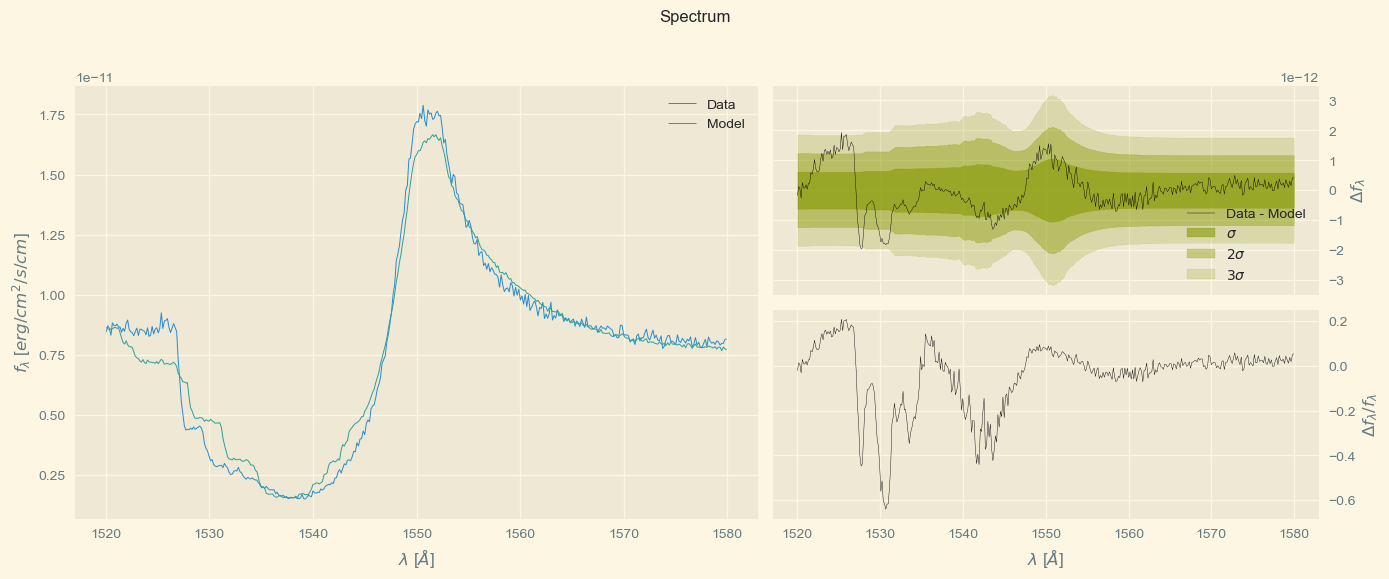

In [25]:
# Stage 12.1) Saving and plotting the trained model
model.plot(yscale="linear")
model.save("Grid-Emulator_Files/Grid_full_MAP.toml")

In [26]:
# Stage 12.2) Reloading the trained model

model.load("Grid-Emulator_Files/Grid_full_MAP.toml")
model.freeze("global_cov")
print(model.labels)

('param1', 'param2', 'param3')


#### <u>Stage 13 - Setting Up Initial Walkers's Position for MCMC</u>


This code block initialises the walker positions for the MCMC with a gaussian ball. The MCMC sampler used is `emcee`. The multiprocessing environment is set with this stage for emcee using the pool process. 

-- You have 3 inputs here! --

The code reads the number of CPU's within your machine and the pooling process will use X-2 for multiprocessing. You can change this if you wish by altering `ncpu = cpu_count() - 2` integer value.

You can now set the number of walkers you wish for the MCMC with `nwalkers`. For processing efficiency, use a multiple of the CPU-2 integer. Eg, $nwalkers = 5\times(CPU-2)$. `max_n` controls the maximum number of steps the MCMC takes. Set this to a high number like 1000 as the code will auto-break when convergence is reached. The `emcee` has a backend too. So if convergence isn't met after maximum steps, you can keep running the sampler in Stage 15 again and again to continue the process from where you left off. The MCMC dimensionality is set for you (`ndim`)with how many unfrozen model parameters you have.

The gaussian ball.... to be continued. 

In [27]:
# Stage 13) Set walkers initial positions/dimensionality and mcmc parameters

os.environ["OMP_NUM_THREADS"] = "1"
mp.set_start_method('fork', force=True)

# ----- Inputs here ------|
ncpu = cpu_count() - 2      # Pool CPU's used.
nwalkers = 3 * ncpu         # Number of walkers in the MCMC.
# Maximum iterations of the MCMC if convergence is not reached.
max_n = 400
extra_steps = int(max_n / 10)  # Extra MCMC steps
# ------------------------|

ndim = len(model.labels)
print("{0} CPUs".format(ncpu))
if kgrid == 1:
    default_scales = {"param1": 1e-11, "param2": 1e-2, "param3": 1e-2,
                      "param4": 1e-2, "param5": 1e+9, "param6": 1e-2}
if shortspec == 1:
    default_scales = {"param1": 1e-1, "param2": 1e-1, "param3": 1e-1}

scales = {}  # Selects the priors required from the model parameters used
for label in model.labels:
    scales[label] = default_scales[label]

# Initialize gaussian ball for starting point of walkers
# scales = {"c1": 1e-10, "c2": 1e-2, "c3": 1e-2, "c4": 1e-2}
# model = model_ball_initial
ball = np.random.randn(nwalkers, ndim)
for i, key in enumerate(model.labels):
    ball[:, i] *= scales[key]
    ball[:, i] += model[key]

6 CPUs


#### <u>Stage 14 - Running the MCMC - Long Runtime</u>

This code block executes the MCMC run. Starfish samples the chains every 10 iterations to check for convergence. If converged, the code will break and complete the MCMC before the max iterations set in Stage 13. 

The code block then executes more MCMC steps after convergence to ensure clean chains or run more steps if convergence hasn't been reached yet.

-- You have one input here! --

`extra steps` - controls the number of extra MCMC steps you want after convergence. Default set as 10% the maximum number of steps set (`max_n`). 

The `log_prob(...)` function is defined which returns the natural logarithm of the posterior probability. The function is set so if for any reason the sampler attempts to go outside your grid space, the probability is return negative infinity (to reimpliment). The emcee backend file is setup in .HDF5 format. 

The code block executes more MCMC steps after convergence to ensure clean chains or run more steps if convergence hasn't been reached yet.

In [28]:
# Stage 14) Running MCMC, maximizing and setting up our backend/sampler

def log_prob(P, priors):
    model.set_param_vector(P)
    return model.log_likelihood(priors)


backend = emcee.backends.HDFBackend(
    "Grid-Emulator_Files/Grid_full_MCMC_chain.hdf5")
backend.reset(nwalkers, ndim)

with Pool(ncpu) as pool:
    sampler = emcee.EnsembleSampler(
        nwalkers, ndim, log_prob, args=(priors,), backend=backend, pool=pool
    )

    index = 0  # Tracking how the average autocorrelation time estimate changes
    autocorr = np.empty(max_n)

    old_tau = np.inf  # This will be useful to testing convergence

    # Now we'll sample for up to max_n steps
    for sample in sampler.sample(ball, iterations=max_n, progress=True):
        # Only check convergence every 10 steps
        if sampler.iteration % 10:
            continue
            # Compute the autocorrelation time so far
            # Using tol=0 means that we'll always get an estimate even
            # if it isn't trustworthy
        tau = sampler.get_autocorr_time(tol=0)
        autocorr[index] = np.mean(tau)
        index += 1
        # skip math if it's just going to yell at us
        if np.isnan(tau).any() or (tau == 0).any():
            continue
            # Check convergence
        converged = np.all(tau * 10 < sampler.iteration)
        converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
        if converged:
            print(f"Converged at sample {sampler.iteration}")
            break
        old_tau = tau

    sampler.run_mcmc(backend.get_last_sample(), extra_steps, progress=True)

  0%|          | 0/400 [00:00<?, ?it/s]/Users/austen/opt/anaconda3/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  2%|▎         | 10/400 [00:41<28:13,  4.34s/it]/Users/austen/opt/anaconda3/lib/python3.9/site-packages/emcee/autocorr.py:38: RuntimeWarning: invalid value encountered in divide
  acf /= acf[0]
100%|██████████| 40/40 [03:48<00:00,  5.71s/it]


#### <u>Stage 15 - Plotting the Raw MCMC Chains</u>

This code block shows the plot trace of the MCMC chains, direct from the MCMC process. 

array([[<Axes: title={'center': 'param1'}>,
        <Axes: title={'center': 'param1'}>],
       [<Axes: title={'center': 'param2'}>,
        <Axes: title={'center': 'param2'}>],
       [<Axes: title={'center': 'param3'}>,
        <Axes: title={'center': 'param3'}>]], dtype=object)

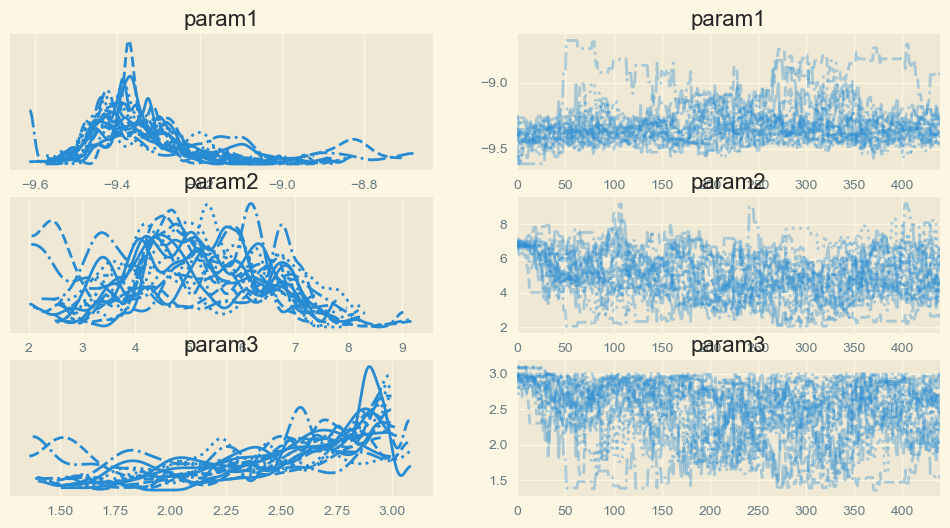

In [29]:
# Stage 15) Plotting raw MCMC chains

reader = emcee.backends.HDFBackend(
    "Grid-Emulator_Files/Grid_full_MCMC_chain.hdf5")
full_data = az.from_emcee(reader, var_names=model.labels)
flatchain = reader.get_chain(flat=True)
az.plot_trace(full_data)

#### <u>Stage 16 - Discarding the Burn-In Section of the Chains</u>

This code block discards the burn-in period of the MCMC chains. The chain is also thinned (understand...)

In [30]:
# Stage 16) Discarding MCMC burn-in

tau = reader.get_autocorr_time(tol=0)
if m.isnan(tau.max()):
    burnin = 0
    thin = 1
    print(burnin, thin)
else:
    burnin = int(tau.max())
    thin = int(0.3 * np.min(tau))
burn_samples = reader.get_chain(discard=burnin, thin=thin)
log_prob_samples = reader.get_log_prob(discard=burnin, thin=thin)
log_prior_samples = reader.get_blobs(discard=burnin, thin=thin)
dd = dict(zip(model.labels, burn_samples.T))
burn_data = az.from_dict(dd)

#### <u>Stage 17 - Plotting the Cleaned MCMC Chains</u>

This code block plots again the trace of the MCMC chains with the burn-in period removed. Summary statistics are also provided from the MCMC.

array([<Axes: title={'center': 'param1'}>,
       <Axes: title={'center': 'param2'}>,
       <Axes: title={'center': 'param3'}>], dtype=object)

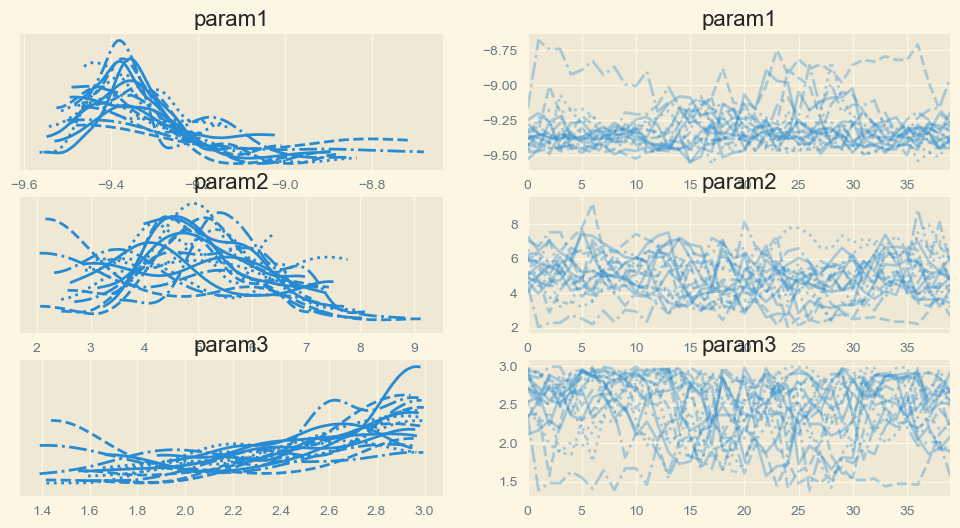

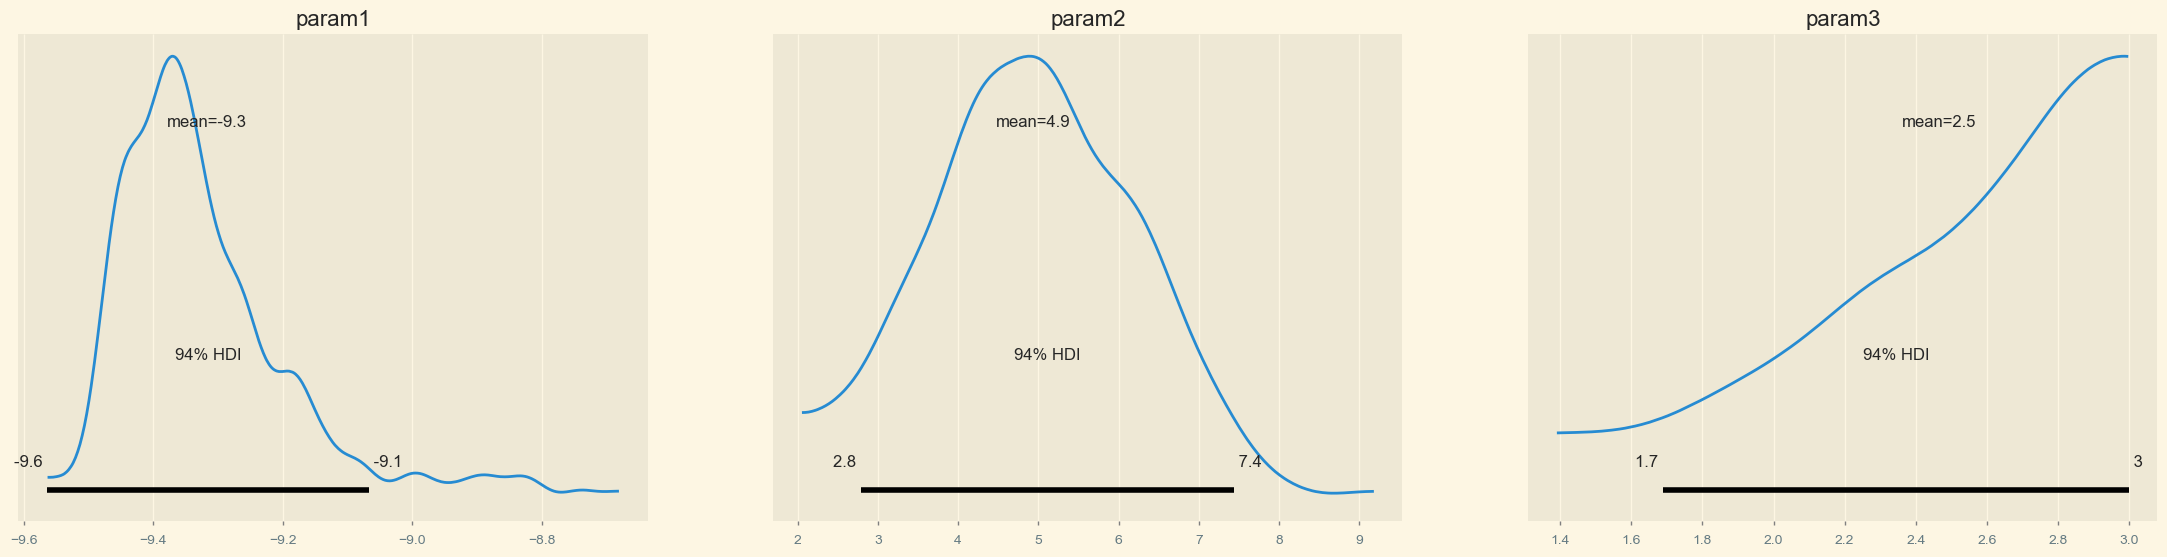

In [31]:
# Stage 17) Chain trace and summary

# Plotting the mcmc chains without the burn-in section,
# summarise our mcmc run's parameters and analysis,
# plot our posteriors of each paramater,
# produce a corner plot of our parameters.
az.plot_trace(burn_data)
az.summary(burn_data, round_to=None)
az.plot_posterior(burn_data, [i for i in model.labels])

#### <u>Stage 18 - Producing a Cornerplot of the Parameters</u>

This code block shows the cornerplot produced by the MCMC. Labelling to be improved....

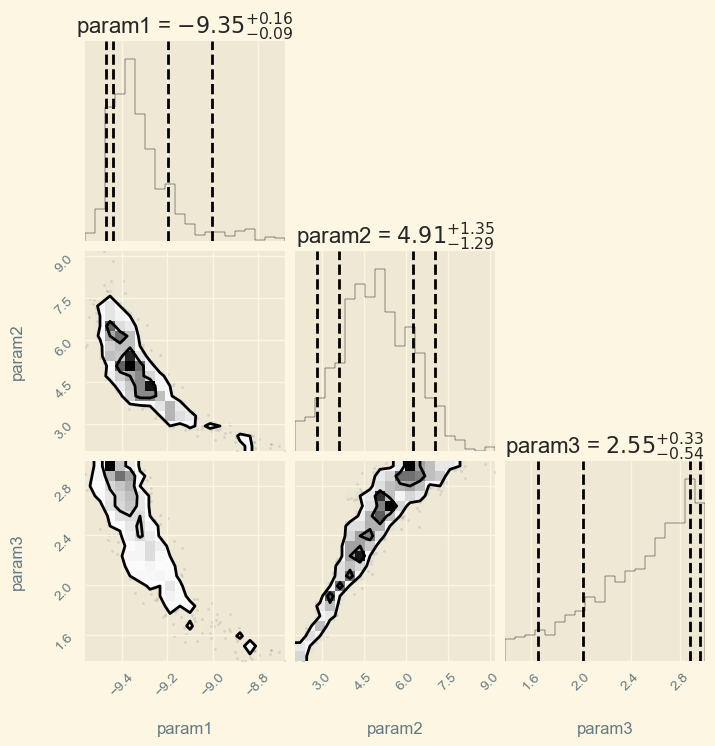

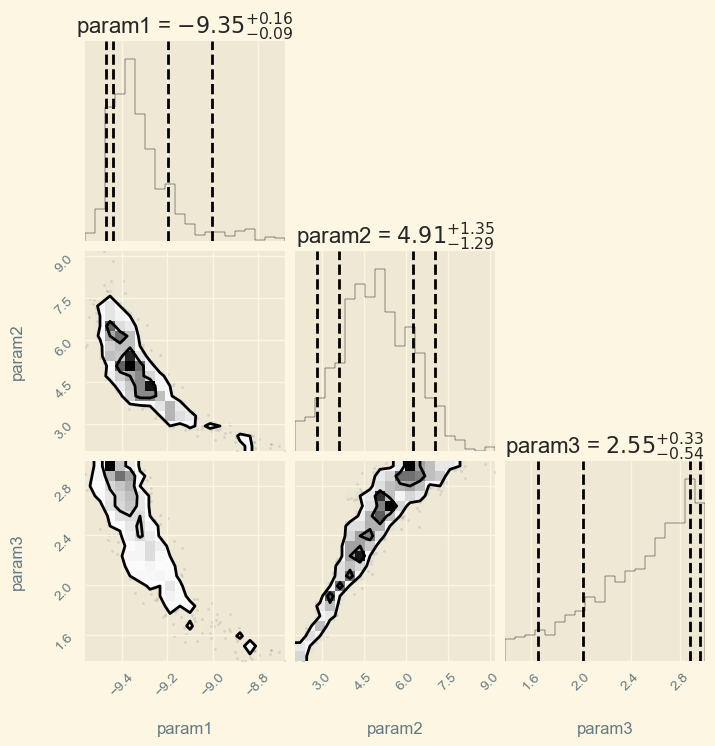

In [32]:
# Stage 18) Cornerplot of our parameters. 

# See https://corner.readthedocs.io/en/latest/pages/sigmas/
sigmas = ((1 - np.exp(-0.5)), (1 - np.exp(-2)))
corner.corner(
    burn_samples.reshape((-1, len(model.labels))),
    labels=model.labels,
    quantiles=(0.05, 0.16, 0.84, 0.95),
    levels=sigmas,
    show_titles=True,
)

#### <u>Stage 19 - Examining the Best Fit Values from the MCMC</u>

This code block remakes the model fit with the MCMC posterior statistics for the parameter's values. 

SpectrumModel
-------------
Data: Spectrum
Emulator: Grid-Emulator_Files/SSpec_emu_linear_60inc_1510-1590AA_4comp_123
Log Likelihood: 11140.42522201174

Parameters
  param1: -9.317222664179827
  param2: 4.9388261763461525
  param3: 2.464652913114156
  log_scale: -25.57622111729285 (fit)

Frozen Parameters
  Av: 0
  global_cov:log_amp: -56.35215153846589
  global_cov:log_ls: 2.8637792334474987


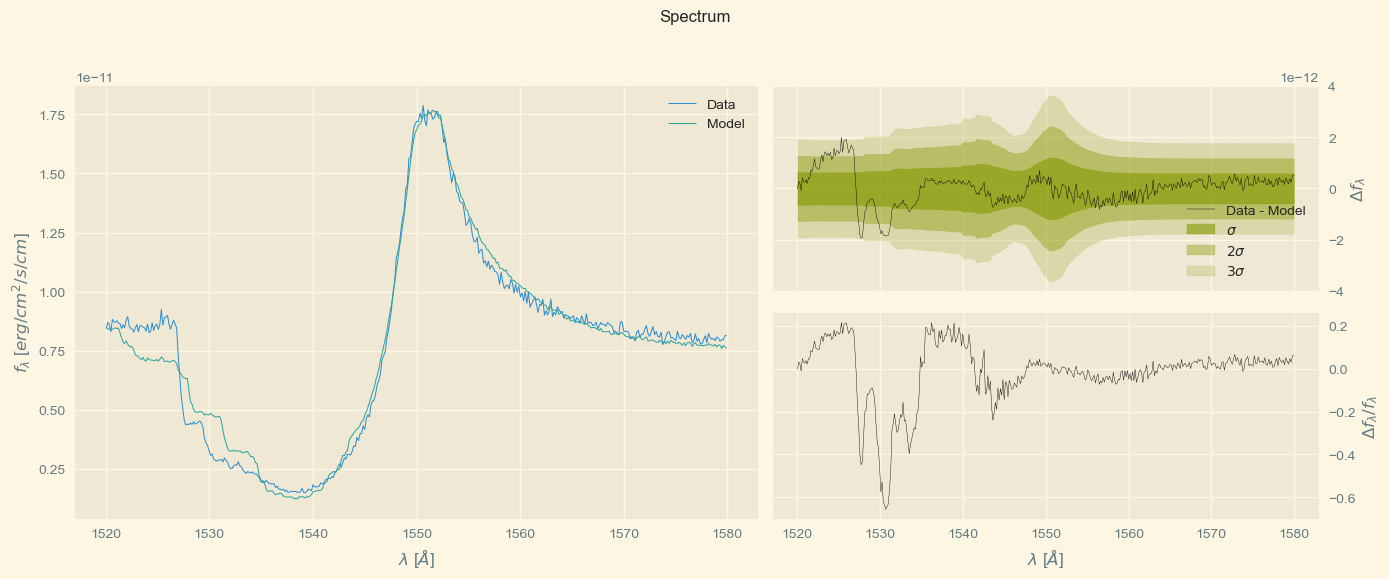

In [33]:
# Stage 19) Plotting Best Fit MCMC parameters

# We examine our best fit parameters from the mcmc chains, plot and save our
# final best fit model spectrum.
ee = [np.mean(burn_samples.T[i]) for i in range(len(burn_samples.T))]
ee = dict(zip(model.labels, ee))
model.set_param_dict(ee)
print(model)
model.plot(yscale="linear")
model.save("Grid-Emulator_Files/Grid_full_parameters_sampled.toml")